In [1]:
# Add module to path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Imports
from aoc23.utils import read_input
from copy import deepcopy
from heapq import heapify, heappop, heappush
from collections import deque, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import networkx as nx

In [3]:
input_22 = read_input(22)

## Dropping the blocks

In part 1 of the [day 22 puzzle](https://adventofcode.com/2023/day/22), we are provided with a collection of blocks which are falling from the sky. Each block is cuboidal in shape, consisting of a line of individual cubic segments, constrained to lie on integer lattice points. The blocks are determined by the integer $(x, y, z)$ coordinates of the start and end blocks. For example, take the block defined by the first line of the input file:

In [4]:
input_22[0]

'2,6,9~5,6,9'

This describes a block which is $4$ units long, starting at the point $(2, 6, 9)$ and finishing at the point $(5, 6, 9)$:

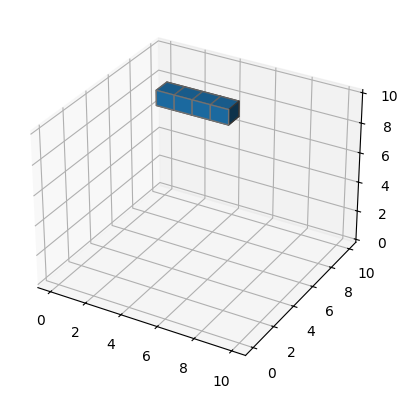

In [5]:
# Create axis
axes = [10, 10, 10]
 
# Create blocks
data = np.zeros(axes)
data[2, 6, 9] = 1
data[3, 6, 9] = 1
data[4, 6, 9] = 1
data[5, 6, 9] = 1

# Plot figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
 
# Plot voxels
ax.voxels(data, edgecolors='grey')
plt.show()

Let's define a class `Block` to represent each block. Each block will track its component cubes, as well as the position in space where the block is located:

In [6]:
class Block:
    
    def __init__(self, ends):
        self.cubes = self._compute_cubes(ends)
        self.length = len(self.cubes)
        self.minx = min(self.cubes[0][0], self.cubes[-1][0])
        self.maxx = max(self.cubes[0][0], self.cubes[-1][0])
        self.miny = min(self.cubes[0][1], self.cubes[-1][1])
        self.maxy = max(self.cubes[0][1], self.cubes[-1][1])
        self.minz = min(self.cubes[0][2], self.cubes[-1][2])
        self.maxz = max(self.cubes[0][2], self.cubes[-1][2])
        self.set_id()
        
    def __repr__(self):
        return self.id
    
    def set_id(self):
        self.id = f'({self.minx}, {self.miny}, {self.minz}) -> ({self.maxx}, {self.maxy}, {self.maxz})'
    
    @staticmethod
    def _compute_cubes(ends):
        # Process the input string into a list of cubes
        end1, end2 = ends.split('~')
        end1 = np.array([int(x) for x in end1.split(',')])
        end2 = np.array([int(x) for x in end2.split(',')])
        
        v = end2 - end1
        length = max(v)
        
        # Construct list of arrays representing cubes
        blocks = [end1 + i*v/max(length, 1) for i in range(length+1)]
        return sorted(blocks, key=lambda x: (x[2], x[1], x[0]))
        
    def __lt__(self, other):
        # Use z-coordinate to provide a partial ordering on the blocks
        return min(self.cubes[0][2], self.cubes[-1][2]) < min(other.cubes[0][2], other.cubes[-1][2])

Demonstrating using the example from earlier:

In [7]:
block = Block('2,6,9~5,6,9')
block.cubes

[array([2., 6., 9.]),
 array([3., 6., 9.]),
 array([4., 6., 9.]),
 array([5., 6., 9.])]

The blocks defined by the input file are initially floating in the air, above the ground; the first task is to 'drop' the blocks, so that they fall on top of each other, forming a pile which is resting on the ground (at $z=0$). We can define another class called `BlockDropper`, which will handle the action of dropping the blocks, and in the process creating a record of the final positions of the dropped blocks. 

The strategy for dropping the blocks is to consider each block one at a time, ordered by their initial $z$-coordinate. For cuboidal blocks, this ordering will mean that no block needs to be dropped more than once. The `__lt__` method of the `Block` class, along with a heap data structure, allows the blocks to be retrieved in this convenient order. Also, the class has a visualization function, to plot the blocks in their current states.

In [8]:
class BlockDropper:
    
    def __init__(self, blocks):
        self.blocks = blocks
        
        # Allows block to be retrieved 
        # by increasing z-coordinate
        heapify(self.blocks)
        
        # Useful variables, to track the resting places of the drops
        self.lowest_free_space = defaultdict(lambda: 1)
        self.xy_entries = defaultdict(lambda: {})
        self.nonzero_drops = 0
        self.is_dropped = False
        
        # Colours for visualization
        self.colors = list(mcolors.TABLEAU_COLORS.keys())
        
    def drop_blocks(self):
        assert not self.is_dropped
        dropped_blocks = []
        self.dropped = {b.id: False for b in self.blocks}
        
        while not all(self.dropped.values()):
            # Retrieve next block
            b = heappop(self.blocks)
            self.dropped[b.id] = True
            
            # Find distance to lowest unoccupied space in z-direction
            drop_distance = min([cube[2] - self.lowest_free_space[(cube[0], cube[1])] 
                                 for cube in b.cubes])
            
            # Keep track of number of blocks dropped
            if drop_distance > 0:
                self.nonzero_drops = self.nonzero_drops + 1
            
            # Update the cube coordinates after drop
            b.cubes = [np.array([cube[0], cube[1], cube[2] - drop_distance])
                       for cube in b.cubes]
            
            # Keep track of which blocks occupy spaces in each x-y column
            for cube in b.cubes:
                self.xy_entries[(cube[0], cube[1])][cube[2]] = b
            
            # Update block z information
            b.minz = b.minz - drop_distance
            b.maxz = b.maxz - drop_distance
            b.set_id()
            
            # Update lowest_free_space, as block now occupies current one
            for cube in b.cubes:
                self.lowest_free_space[(cube[0], cube[1])] = \
                    max(self.lowest_free_space[(cube[0], cube[1])], cube[2]) + 1
            
            dropped_blocks.append(b)
        
        self.is_dropped = True
        self.blocks = dropped_blocks
    
    def visualize_blocks(self, **fig_args):
        # Create axes
        minx = np.min([b.minx for b in self.blocks])
        maxx = np.max([b.maxx for b in self.blocks])
        miny = np.min([b.miny for b in self.blocks])
        maxy = np.max([b.maxy for b in self.blocks])
        minz = np.min([b.minz for b in self.blocks])
        maxz = np.max([b.maxz for b in self.blocks])
        
        axes = [int(maxx)+1, int(maxy)+1, int(maxz)+1]

        # Create data
        data = np.zeros(axes)
        colors = np.empty(data.shape, dtype=object)
        for i, block in enumerate(self.blocks):
            for cube in block.cubes:
                coords = [int(cube[0]), int(cube[1]), int(cube[2])-1]
                data[*coords] = 1
                colors[*coords] = self.colors[i % len(self.colors)]

        # Plot figure
        fig = plt.figure(**fig_args)
        ax = fig.add_subplot(111, projection='3d')

        ax.voxels(data, facecolors=colors, alpha=0.8)
        ax.set_box_aspect((maxx-minx, maxy-miny, maxz-1))
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_zticklabels([])
        return fig, ax

The puzzle has provided us a example set of blocks, to test the `drop_blocks` function:

In [9]:
test_input = [
    '1,0,1~1,2,1',
    '0,0,2~2,0,2',
    '0,2,3~2,2,3',
    '0,0,4~0,2,4',
    '2,0,5~2,2,5',
    '0,1,6~2,1,6',
    '1,1,8~1,1,9'
]

In [10]:
test_dropper = BlockDropper([Block(b) for b in test_input])
test_dropper.blocks

[(1.0, 0.0, 1.0) -> (1.0, 2.0, 1.0),
 (0.0, 0.0, 2.0) -> (2.0, 0.0, 2.0),
 (0.0, 2.0, 3.0) -> (2.0, 2.0, 3.0),
 (0.0, 0.0, 4.0) -> (0.0, 2.0, 4.0),
 (2.0, 0.0, 5.0) -> (2.0, 2.0, 5.0),
 (0.0, 1.0, 6.0) -> (2.0, 1.0, 6.0),
 (1.0, 1.0, 8.0) -> (1.0, 1.0, 9.0)]

In [11]:
test_dropper.blocks[0].cubes

[array([1., 0., 1.]), array([1., 1., 1.]), array([1., 2., 1.])]

As seen here, each block consists of a list of arrays, representing the centres of each component cube. We can visualize the starting positions of all of the blocks:

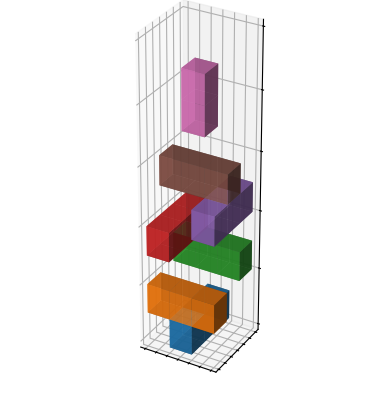

In [12]:
fig, ax = test_dropper.visualize_blocks()

After dropping the blocks, they will rest atop each other in a stack, which itself rest on the ground (the $z=0$ plane):

In [13]:
test_dropper.drop_blocks()
test_dropper.blocks

[(1.0, 0.0, 1.0) -> (1.0, 2.0, 1.0),
 (0.0, 0.0, 2.0) -> (2.0, 0.0, 2.0),
 (0.0, 2.0, 2.0) -> (2.0, 2.0, 2.0),
 (0.0, 0.0, 3.0) -> (0.0, 2.0, 3.0),
 (2.0, 0.0, 3.0) -> (2.0, 2.0, 3.0),
 (0.0, 1.0, 4.0) -> (2.0, 1.0, 4.0),
 (1.0, 1.0, 5.0) -> (1.0, 1.0, 6.0)]

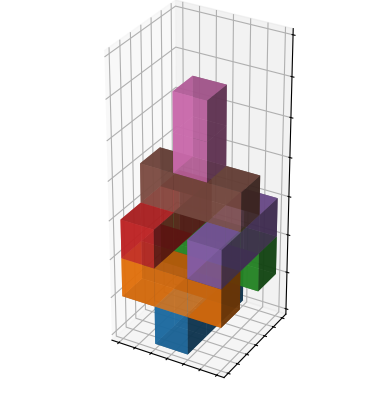

In [14]:
fig, ax = test_dropper.visualize_blocks()

As expected, this matches the description given in the puzzle. Let's try this now for the full set of blocks:

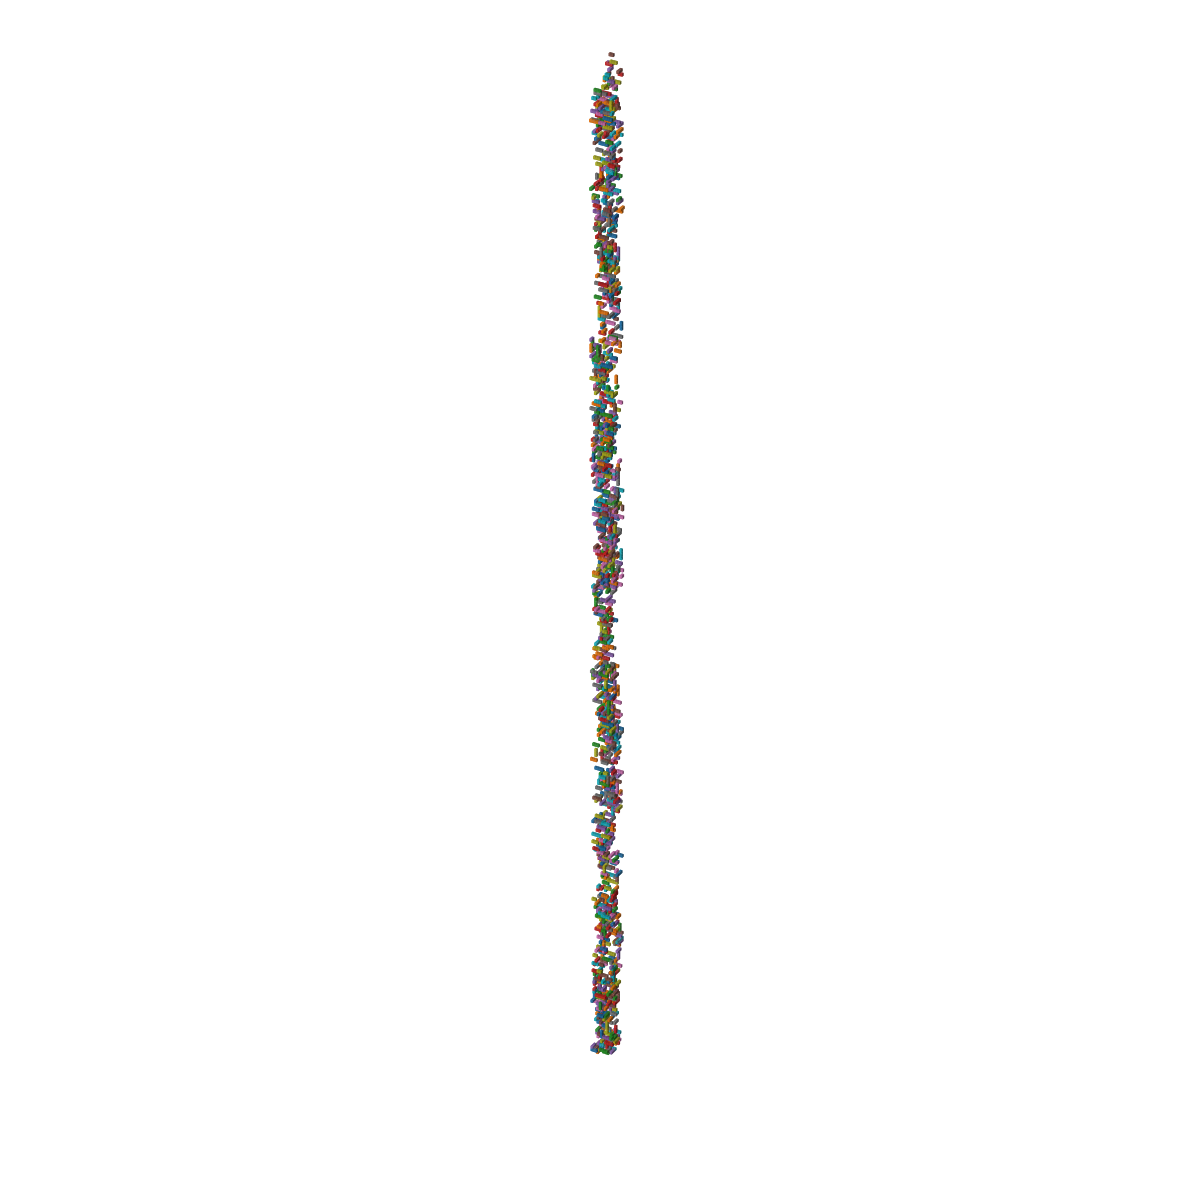

In [15]:
dropper = BlockDropper([Block(b) for b in input_22])
fig, ax = dropper.visualize_blocks(figsize=(15, 20))
ax.set_axis_off()

In [16]:
dropper.drop_blocks()

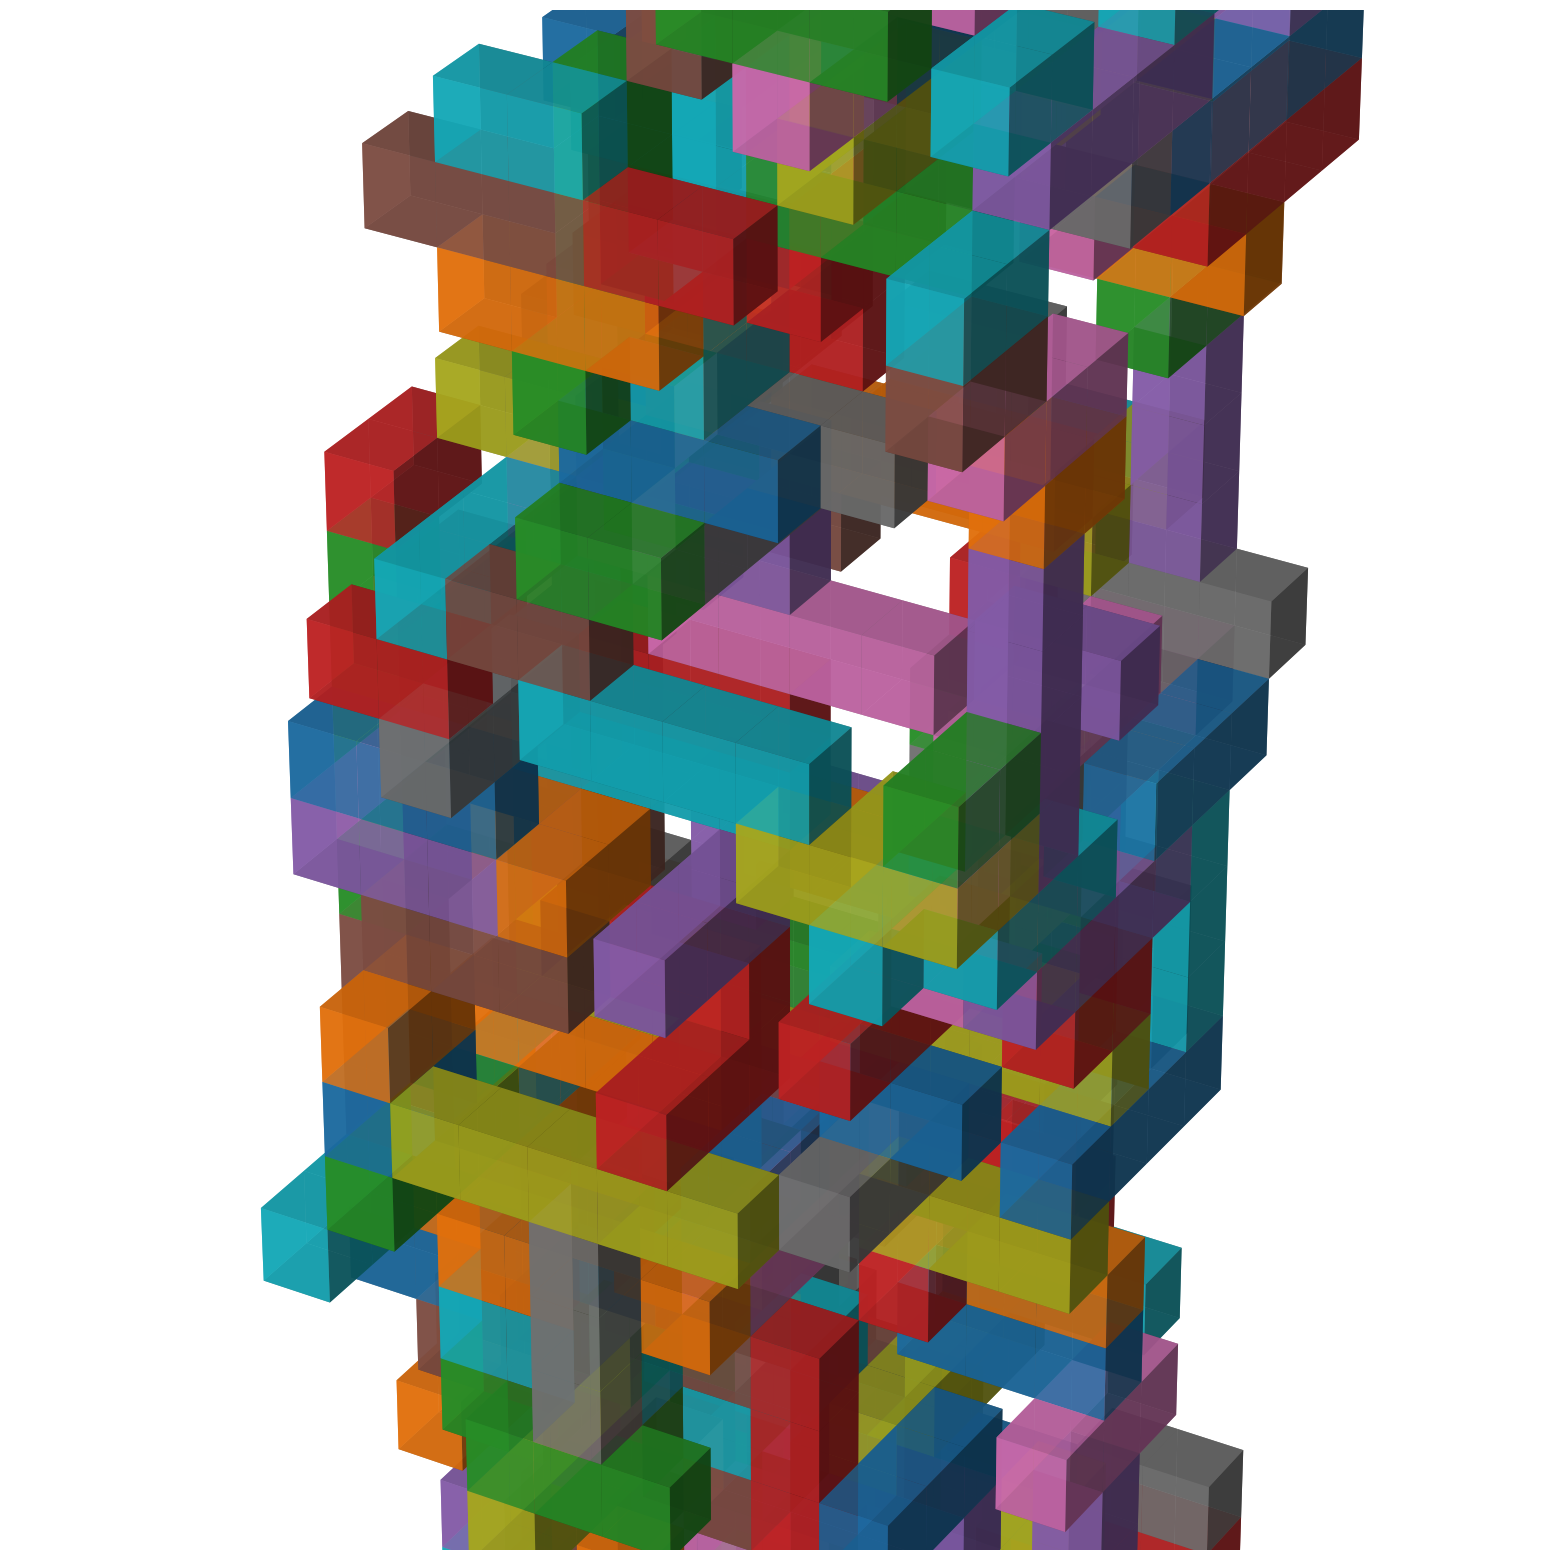

In [22]:
fig, ax = dropper.visualize_blocks(figsize=(20, 20))
ax.set_axis_off()
ax.set_zlim(10, 20)
ax.set_box_aspect((1, 1, 1))

## Counting the number of falling blocks

The two parts of this puzzle ask for the following:
1. The number of blocks which, when disintegrated, do not result in any other blocks falling.
2. For each block, the number of other blocks which fall when the block is disintegrated.

My initial thoughts for the way to compute this were to do something like the following:

However, this requires creating a separate `DropBlocks` instance for every block in the stack, and runnning the `drop_blocks` methods for each of them (which itself loops over all blocks), so I quickly moved onto an alternative method.

A key insight is that the exact shapes and positions of the blocks does not really matter - what is important is the way in which the blocks lie relative to each other. In particular, all the necessary detail required is contained in a `dict` which maps each block to the other blocks which lie immediately on top of it (i.e. are 'supported' by it). Equivalently, we could construct a `dict` which maps each block to the other blocks which it lies on top of. The following function computes both of these objects, given a `BlockDropper`:

In [17]:
def compute_support(dropper):
    # The two dicts to construct
    support = {block: set() for block in dropper.blocks}
    atop = {block: set() for block in dropper.blocks}
    
    xy = dropper.xy_entries
    
    # For each (x,y) position, find blocks which
    # lie in neighbouring z slots
    for x, y in xy.keys():
        for z, block in xy[(x, y)].items():
            if z+1 in xy[(x, y)]:
                support[block].add(xy[(x, y)][z+1])
                atop[xy[(x, y)][z+1]].add(block)
                
    # Remove blocks which are in their own support/atop entry
    # (happens when block is oriented vertically)
    for k in support:
        while k in support[k]:
            support[k].remove(k)
            
    for k in atop:
        while k in atop[k]:
            atop[k].remove(k)
    
    return support, atop

In [18]:
test_support, test_atop = compute_support(test_dropper)
support, atop = compute_support(dropper)

These dictionaries define directed graphs, where each node is a block and each directed edge $a\rightarrow b$ from represents a block $b$ which supports/is supported by block $a$. In fact, the directed graph defined by the `support` dictionary is the transpose of the directed graph defined by the `atop` dictionary (obtained by reversing the direction of all the directed edges). The essential structure of the blocks after they have been dropped looks like this, when visualised as as a directed graph:

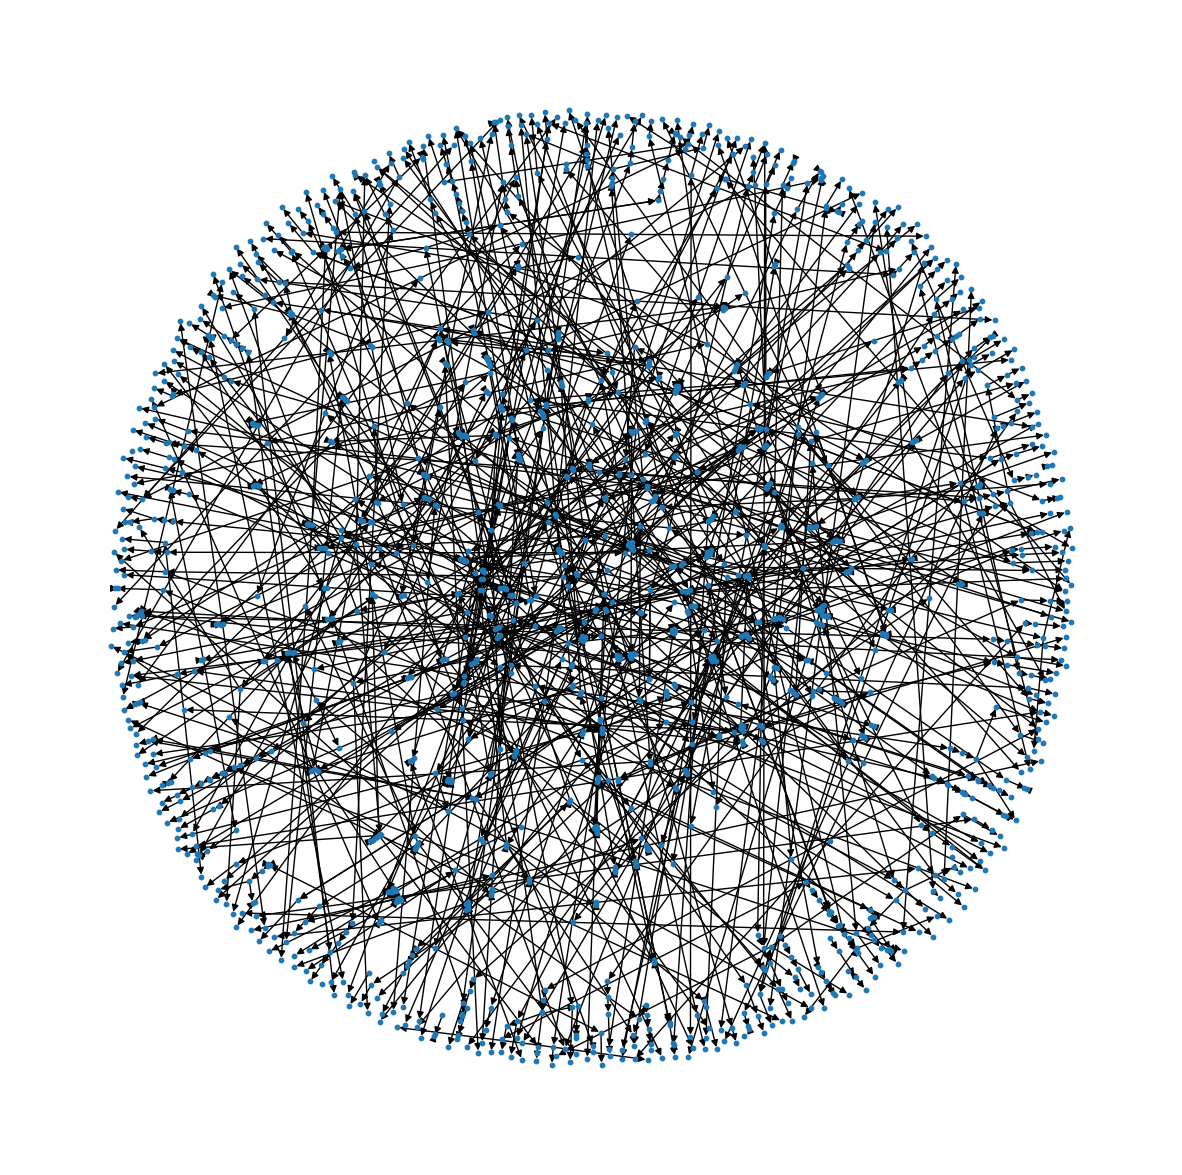

In [19]:
graph = nx.DiGraph(support)

fig, ax = plt.subplots(figsize=(15, 15))
nx.draw(graph, pos=nx.spring_layout(graph, iterations=150), node_size=10, ax=ax)

Given this graph representation of the blocks, how can we compute the number of blocks dependent on a specific block? It is not as simple as counting the number of nodes reachable from the block node via directed edges, as one of these nodes may also be supported by a blocks that is not dependent on the original block. The visualization of the small example set of blocks earlier illustrates this - the brown block is supported by the red block, but will not fall if the red block is disintegrated as it is also supported by the purple block.

The strategy for computing this number, given a specific block, is to use a `deque` to track potential blocks. The blocks also have a flag, indicating whether they are currently falling. Each time a block is retrieved from the front of the queue, it is only considered if all of the blocks that support it are also currently falling. If so, the blocks that are atop it are added to the queue and the falling flag for the block is set to True; otherwise, it is being supported by another block, so no action is taken.

In [20]:
def compute_n_falling(block, support, atop):
    # Falling flags for all blocks
    is_falling = {b: False for b in support}
    
    # Block under consideration is
    # considered to be falling
    is_falling[block] = True
    
    # Add block to queue
    queue = deque(support[block])
    while queue:
        
        # Consider next block n queue
        b = queue.popleft()
        
        if all([is_falling[a] for a in atop[b]]):
            # Update flag
            is_falling[b] = True
            
            # Add all dependents to queue
            for c in support[b]:
                queue.append(c)
    
    # Return number of falling blocks 
    # (minus first block)
    return sum(is_falling.values()) - 1

Let's demonstrate this approach on the small set of example blocks we visualized earlier:

In [21]:
for b in test_support:
    print(f'Disintegrate block {b}, causing {compute_n_falling(b, test_support, test_atop)} other blocks to fall')

Disintegrate block (1.0, 0.0, 1.0) -> (1.0, 2.0, 1.0), causing 6 other blocks to fall
Disintegrate block (0.0, 0.0, 2.0) -> (2.0, 0.0, 2.0), causing 0 other blocks to fall
Disintegrate block (0.0, 2.0, 2.0) -> (2.0, 2.0, 2.0), causing 0 other blocks to fall
Disintegrate block (0.0, 0.0, 3.0) -> (0.0, 2.0, 3.0), causing 0 other blocks to fall
Disintegrate block (2.0, 0.0, 3.0) -> (2.0, 2.0, 3.0), causing 0 other blocks to fall
Disintegrate block (0.0, 1.0, 4.0) -> (2.0, 1.0, 4.0), causing 1 other blocks to fall
Disintegrate block (1.0, 1.0, 5.0) -> (1.0, 1.0, 6.0), causing 0 other blocks to fall


As expected, the only times that blocks fall are:
- When the brown block is removed (so only the pink block falls),
- When the blue block is removed (so the 6 remaining blocks all fall).

With this function, we can count the blocks that will cause other blocks to fall when disintegrated, as well as the number of blocks that will fall:

In [22]:
test_falling_blocks = [compute_n_falling(b, test_support, test_atop) for b in test_dropper.blocks]

assert sum([n == 0 for n in test_falling_blocks]) == 5
assert sum(test_falling_blocks) == 7
print('Success!')

Success!


Finally, let's repeat this for the full set of blocks:

In [23]:
falling_blocks = [compute_n_falling(b, support, atop) for b in dropper.blocks]

In [24]:
sum([n == 0 for n in falling_blocks])

512

In [25]:
sum(falling_blocks)

98167

So the answer to part 1 is __512__, and the answer to part 2 is __98167__.